In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage import data
from skimage.util import img_as_ubyte
from skimage.filters.rank import entropy
from skimage.morphology import disk
from mpl_toolkits.mplot3d import Axes3D

In [2]:
rgb_img = cv2.imread('/home/shri/Downloads/IMG.jpeg')

In [3]:
img = cv2.imread('/home/shri/Downloads/IMG.jpeg',0)
print('Image height :',img.shape[0])
print('Image height :',img.shape[1])

Image height : 220
Image height : 220


## Histogram

- Gray_Histogram

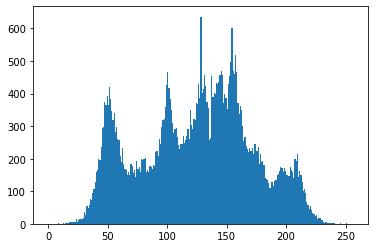

In [4]:
plt.hist(img.ravel(),256,[0,256]); plt.show()

- RGB_histogram

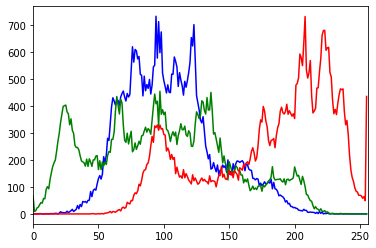

In [5]:
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([rgb_img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

- 3d R-G-B

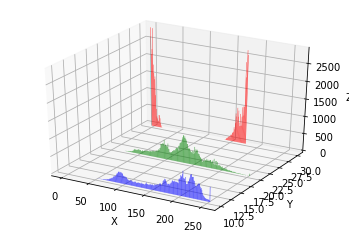

In [6]:
hsv = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2HSV)
h,s,v = cv2.split(hsv)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for x, c, z in zip([h,s,v], ['r', 'g', 'b'], [30, 20, 10]):
    xs = np.arange(256)
    ys = cv2.calcHist([x], [0], None, [256], [0,256])
    cs = [c] * len(xs)
    cs[0] = 'c'
    ax.bar(xs, ys.ravel(), zs=z, zdir='y', color=cs, alpha=0.8)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

# Entropy

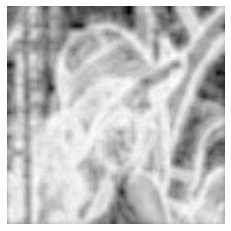

In [7]:
entropy_img = entropy(img, disk(5))
plt.imshow(entropy_img, cmap='gray')
plt.axis("off")
plt.show()

GLCM approch to calculate first and second order analysis.

In [8]:
def fast_glcm(img, vmin=0, vmax=255, nbit=8, kernel_size=5):
    mi, ma = vmin, vmax
    ks = kernel_size
    h,w = img.shape

    # digitize
    bins = np.linspace(mi, ma+1, nbit+1)
    gl1 = np.digitize(img, bins) - 1
    gl2 = np.append(gl1[:,1:], gl1[:,-1:], axis=1)

    # make glcm
    glcm = np.zeros((nbit, nbit, h, w), dtype=np.uint8)
    for i in range(nbit):
        for j in range(nbit):
            mask = ((gl1==i) & (gl2==j))
            glcm[i,j, mask] = 1

    kernel = np.ones((ks, ks), dtype=np.uint8)
    for i in range(nbit):
        for j in range(nbit):
            glcm[i,j] = cv2.filter2D(glcm[i,j], -1, kernel)

    glcm = glcm.astype(np.float32)
    return glcm

### 1. Mean

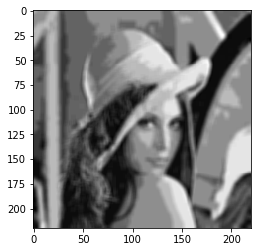

In [9]:
def fast_glcm_mean(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm mean
    '''
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    mean = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            mean += glcm[i,j] * i / (nbit)**2

    return mean


mean = fast_glcm_mean(img)
plt.imshow(mean, cmap='gray')
#plt.axis("off")
plt.show()

### 2. Standard Deviation

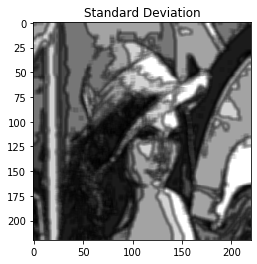

In [10]:
def fast_glcm_std(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm std
    '''
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    mean = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            mean += glcm[i,j] * i / (nbit)**2

    std2 = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            std2 += (glcm[i,j] * i - mean)**2

    std = np.sqrt(std2)
    return std

std = fast_glcm_std(img)
plt.imshow(std, cmap='gray')
plt.title(label='Standard Deviation',loc='center')
#plt.axis("off")
plt.show()

### 3. Contrast

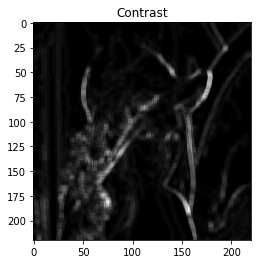

In [11]:
def fast_glcm_contrast(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm contrast
    '''
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    cont = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            cont += glcm[i,j] * (i-j)**2

    return cont

cont = fast_glcm_contrast(img)
plt.imshow(cont, cmap='gray')
plt.title(label='Contrast',loc='center')
#plt.axis("off")
plt.show()

### 4. Contrast

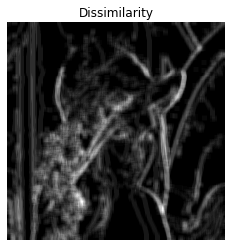

In [12]:
def fast_glcm_dissimilarity(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm dissimilarity
    '''
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    diss = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            diss += glcm[i,j] * np.abs(i-j)

    return diss

diss = fast_glcm_dissimilarity(img)

plt.imshow(diss, cmap='gray')
plt.title(label='Dissimilarity',loc='center')
plt.axis("off")
plt.show()

### 5. Homogeneity

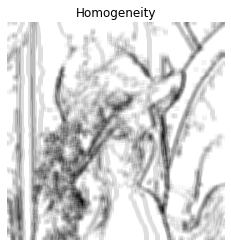

In [13]:
def fast_glcm_homogeneity(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm homogeneity
    '''
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    homo = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            homo += glcm[i,j] / (1.+(i-j)**2)

    return homo

homo = fast_glcm_homogeneity(img)

plt.imshow(homo, cmap='gray')
plt.title(label='Homogeneity',loc='center')
plt.axis("off")
plt.show()

### 6. ASM 

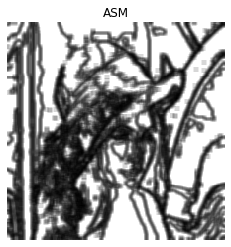

In [14]:
def fast_glcm_ASM(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm asm, energy
    '''
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    asm = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            asm  += glcm[i,j]**2

    ene = np.sqrt(asm)
    return asm, ene
   
asm, ene = fast_glcm_ASM(img)
plt.imshow(asm, cmap='gray')
plt.title(label='ASM',loc='center')
plt.axis("off")
plt.show()

### 7. GLCM_Max

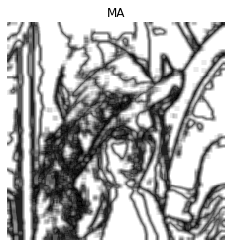

In [15]:
def fast_glcm_max(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm max
    '''
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    max_  = np.max(glcm, axis=(0,1))
    return max_

ma = fast_glcm_max(img)

plt.imshow(ma, cmap='gray')
plt.title(label='MA',loc='center')
plt.axis("off")
plt.show()

### 8. GLCM_Entropy

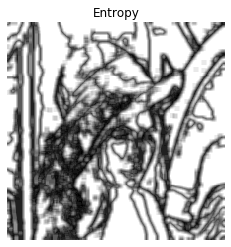

In [16]:
def fast_glcm_entropy(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm entropy
    '''
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    pnorm = glcm / np.sum(glcm, axis=(0,1)) + 1./ks**2
    ent  = np.sum(-pnorm * np.log(pnorm), axis=(0,1))
    return ent

ent = fast_glcm_entropy(img)

plt.imshow(ma, cmap='gray')
plt.title(label='Entropy',loc='center')
plt.axis("off")
plt.show()

## Edge Detection Filters

### 1. -  Canny Edge Detector 

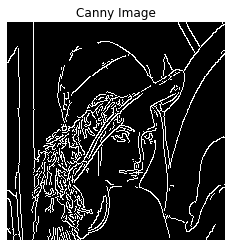

In [17]:
edges = cv2.Canny(img,100,200)

plt.imshow(edges,cmap = 'gray')
plt.title('Canny Image')
plt.axis('off')
plt.show()


### 2. Prewitt

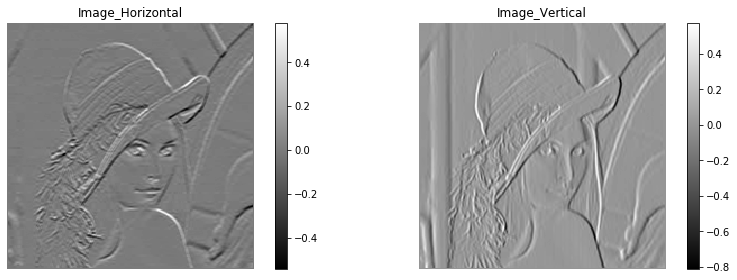

In [18]:
from skimage.filters import prewitt_h,prewitt_v
#calculating horizontal edges using prewitt kernel
edges_prewitt_horizontal = prewitt_h(img)
#calculating vertical edges using prewitt kernel
edges_prewitt_vertical = prewitt_v(img)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 4), sharex=True, sharey=True)
img0 = ax0.imshow(edges_prewitt_horizontal, cmap=plt.cm.gray)
ax0.set_title("Image_Horizontal")
ax0.axis("off")
fig.colorbar(img0, ax=ax0)
entropy_img = entropy(img, disk(5))
img1 = ax1.imshow(edges_prewitt_vertical, cmap='gray')
ax1.set_title("Image_Vertical")
ax1.axis("off")
fig.colorbar(img1, ax=ax1)
fig.tight_layout()
plt.show()

## Cornel Detection

### 1. Shi-Tomasi Corner Detector 

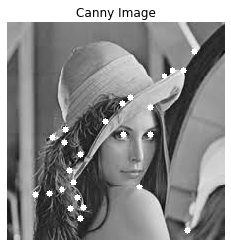

In [19]:
corners = cv2.goodFeaturesToTrack(img,25,0.01,10)
corners = np.int0(corners)

for i in corners:
    x,y = i.ravel()
    cv2.circle(img,(x,y),3,255,-1)

plt.imshow(img,cmap = 'gray')
plt.title('Canny Image')
plt.axis('off')
plt.show()

Second Trial

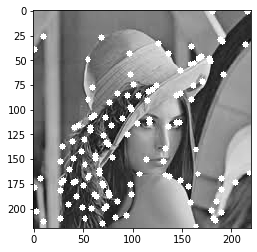

In [20]:
# organizing imports  
import cv2 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 

# Shi-Tomasi corner detection function 
# We are detecting only 100 best corners here 
# You can change the number to get desired result. 
corners = cv2.goodFeaturesToTrack(img, 100, 0.01, 10) 
  
# convert corners values to integer 
# So that we will be able to draw circles on them 
corners = np.int0(corners) 
  
# draw red color circles on all corners 
for i in corners: 
    x, y = i.ravel() 
    cv2.circle(img, (x, y), 3, (255, 0, 0), -1) 

plt.imshow(img, cmap = 'gray') 
  
# De-allocate any associated memory usage   
if cv2.waitKey(0) & 0xff == 27:  
    cv2.destroyAllWindows() 

### 3. Hessian

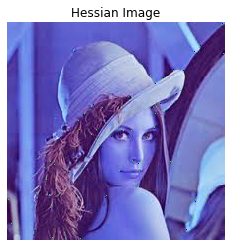

In [21]:
import cv2
import numpy as np

filename = '/home/shri/Downloads/IMG.jpeg'
img = cv2.imread(filename)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# find Harris corners
gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,3,0.04)
dst = cv2.dilate(dst,None)
ret, dst = cv2.threshold(dst,0.01*dst.max(),255,0)
dst = np.uint8(dst)

# find centroids
ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)

# define the criteria to stop and refine the corners
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)

# Now draw them
res = np.hstack((centroids,corners))
res = np.int0(res)
img[res[:,1],res[:,0]]=[0,0,255]
img[res[:,3],res[:,2]] = [0,255,0]

#cv2.imwrite('subpixel5.png',img)
plt.imshow(img,cmap = 'gray')
plt.title('Hessian Image')
plt.axis('off')
plt.show()

### 4. SASAN

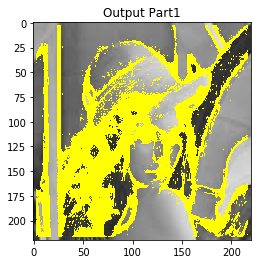

In [22]:
 
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import math
import matplotlib.cm as cm


# function to calculate gaussian
def gaussian(sigma,x):
    a= 1/(np.sqrt(2*np.pi)*sigma)
    b=math.exp(-(x**2)/(2*(sigma**2)))

    c = a*b
    return a*b

# kernel [-1,0,1]
def gaussian_kernel(sigma):
    a=gaussian(sigma, -1)
    b=gaussian(sigma, 0)
    c=gaussian(sigma, 1)
    sum=a+b+c
    if sum!=0:
        a=a/sum
        b=b/sum
        c=c/sum
    return np.reshape(np.asarray([a,b,c]), (1,3))

#susam mask of 37 pixels
def susan_mask():
    mask=np.ones((7,7))
    mask[0,0]=0
    mask[0,1]=0
    mask[0,5]=0
    mask[0,6]=0
    mask[1,0]=0
    mask[1,6]=0
    mask[5,0]=0
    mask[5,6]=0
    mask[6,0]=0
    mask[6,1]=0
    mask[6,5]=0
    mask[6,6]=0
    return mask

def create10by10Mask():
    arr= np.array([[255,0,0,0,0,0,0,0,0,0],[255,255,0,0,0,0,0,0,0,0],[255,255,255,0,0,0,0,0,0,0],[255,255,255,255,0,0,0,0,0,0],[255,255,255,255,255,0,0,0,0,0],[255,255,255,255,255,0,0,0,0,0],[255,255,255,255,0,0,0,0,0,0],[255,255,255,0,0,0,0,0,0,0],[255,255,0,0,0,0,0,0,0,0],[255,0,0,0,0,0,0,0,0,0]])
    return arr
def denoising_img(image):
    output =image.copy()
    for i in range(1,image.shape[0]-1):
        for j in range(1,image.shape[1]-1):
            output[i,j]=np.median([output[i-1][j],output[i+1][j],output[i][j-1],output[i][j+1],output[i-1][j-1],output[i+1][j+1],output[i+1][j-1],output[i-1][j+1]])

    return output

def smoothing(image):
    G=gaussian_kernel(0.5)
    I=cv.filter2D(image,-1,G+np.transpose(G))

    return I

def normalization(image):
    output=image.copy()
    output=output*(np.max(output)-np.min(output))/255
    return output

def plot_image(image,title):
	plt.figure()

	plt.title(title)
	plt.imshow(image,cmap = 'gray')

	plt.show()
def plot_multipleImage(img1,title1,img2,title2,img3,title3,img4,title4):
    plt.subplot(221)
    plt.imshow(img1, cmap=cm.gray)
    plt.title(title1)

    plt.subplot(222)
    plt.imshow(img2, cmap=cm.gray)
    plt.title(title2)

    plt.subplot(223)
    plt.imshow(img3, cmap=cm.gray)
    plt.title(title3)

    plt.subplot(224)
    plt.imshow(img4, cmap=cm.gray)
    plt.title(title4)
    plt.show()




def susan_corner_detection(img):
    img = img.astype(np.float64)
    g=37/2
    circularMask=susan_mask()
    #print circularMask
    # img=create10by10Mask()
    # print(img)
    output=np.zeros(img.shape)
    #val=np.ones((7,7))

    for i in range(3,img.shape[0]-3):
        for j in range(3,img.shape[1]-3):
            ir=np.array(img[i-3:i+4, j-3:j+4])
            ir =  ir[circularMask==1]
            ir0 = img[i,j]
            a=np.sum(np.exp(-((ir-ir0)/10)**6))
            if a<=g:
                a=g-a
            else:
                a=0
            output[i,j]=a
    return output

img=cv.imread("/home/shri/Downloads/IMG.jpeg",0)
output1 = susan_corner_detection(img)
finaloutput1 = cv.cvtColor(img, cv.COLOR_GRAY2RGB)
finaloutput1[output1 != 0] = [255, 255, 0]
plot_image(finaloutput1, "Output Part1")  # good success

### 5.FAST

In [23]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Load the image
image1 = cv2.imread('/home/shri/Downloads/IMG.jpeg')

# Convert  image to RGB
image = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

# Convert image to gray scale
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

Number of Keypoints Detected In The Image With Non Max Suppression:  1145
Number of Keypoints Detected In The Image Without Non Max Suppression:  4011


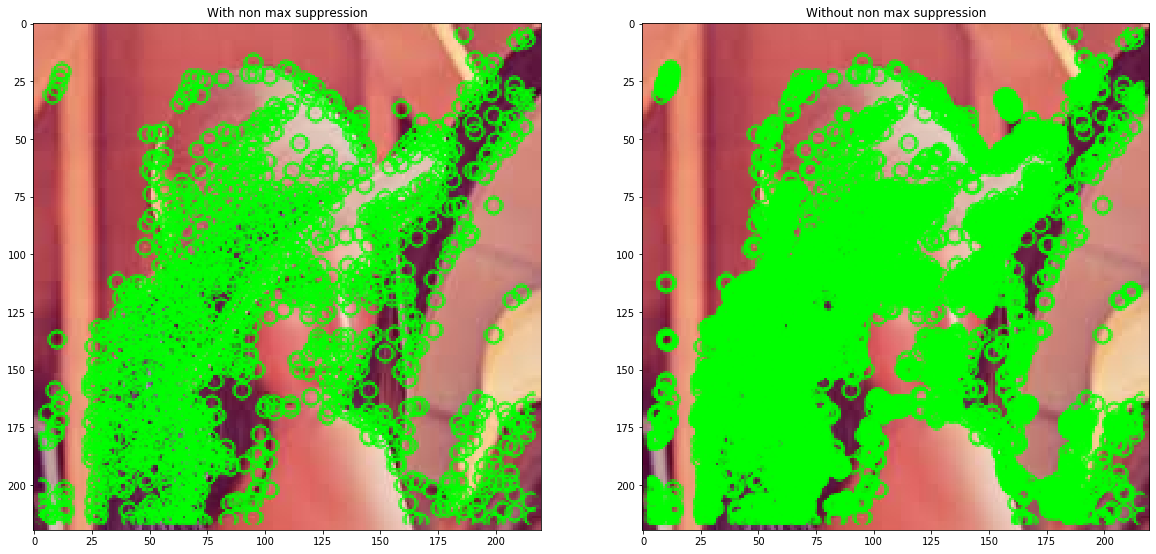

In [24]:
fast = cv2.FastFeatureDetector_create() 

# Detect keypoints with non max suppression
keypoints_with_nonmax = fast.detect(gray, None)

# Disable nonmaxSuppression 
fast.setNonmaxSuppression(False)

# Detect keypoints without non max suppression
keypoints_without_nonmax = fast.detect(gray, None)

image_with_nonmax = np.copy(image)
image_without_nonmax = np.copy(image)

# Draw keypoints on top of the input image
cv2.drawKeypoints(image, keypoints_with_nonmax, image_with_nonmax, color=(0,255,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.drawKeypoints(image, keypoints_without_nonmax, image_without_nonmax, color=(0,255,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display image with and without non max suppression
fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].set_title("With non max suppression")
plots[0].imshow(image_with_nonmax)

plots[1].set_title("Without non max suppression")
plots[1].imshow(image_without_nonmax)

# Print the number of keypoints detected in the training image
print("Number of Keypoints Detected In The Image With Non Max Suppression: ", len(keypoints_with_nonmax))

# Print the number of keypoints detected in the query image
print("Number of Keypoints Detected In The Image Without Non Max Suppression: ", len(keypoints_without_nonmax))

In [25]:
import cv2
img = cv2.imread('/home/shri/Downloads/IMG.jpeg')

### Blob Detection

### 1. Laplacian

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


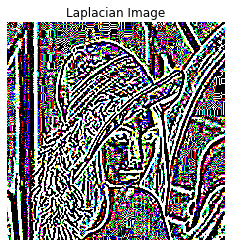

In [26]:
# Apply Gaussian Blur
blur = cv2.GaussianBlur(rgb_img,(3,3),0)
# Apply Laplacian operator in some higher datatype
laplacian = cv2.Laplacian(blur,cv2.CV_64F)
# But this tends to localize the edge towards the brighter side.
#laplacian1 = laplacian/laplacian.max()
plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian Image')
plt.axis('off')
plt.show()

### 1. Main Types
    1. Laplacian of Gaussians
    2. Difference of Gaussians
    3. Determinant of Hessian

In [27]:
from skimage import data, feature, color,img_as_float
from matplotlib import pyplot as plt

In [28]:
from math import sqrt
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray

import matplotlib.pyplot as plt

#image = cv2.imread('/home/shri/Downloads/IMG.jpeg')
image_gray= cv2.imread('/home/shri/Downloads/IMG.jpeg',0)

blobs_log = blob_log(image_gray, max_sigma=30, num_sigma=10, threshold=.1)

# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

blobs_dog = blob_dog(image_gray, max_sigma=30, threshold=.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

blobs_doh = blob_doh(image_gray, max_sigma=30, threshold=.01)

blobs_list = [blobs_log, blobs_dog, blobs_doh]

/home/shri/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/shri/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/shri/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/shri/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))
/home/shri/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)


In [29]:
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian',
          'Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)

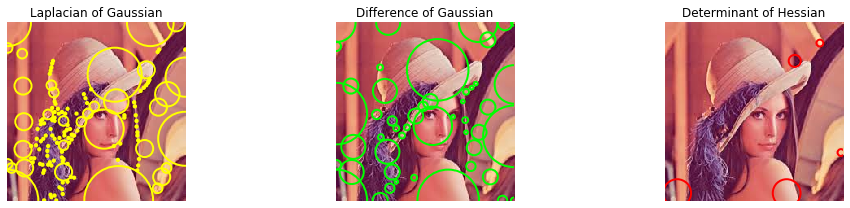

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3), sharex=True, sharey=True)
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(image)
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()

### 2.MSER

In [ ]:
import cv2
img= cv2.imread('/home/shri/Downloads/IMG.jpeg')
vis = img.copy()
mser = cv2.MSER()
regions = mser.detect(img, None)
hulls = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in regions]
cv2.polylines(vis, hulls, 1, (0, 255, 0))
cv2.imshow('img', vis)
cv2.waitKey(0)
cv2.destroyAllWindows()

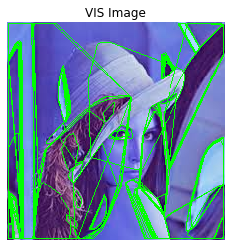

In [31]:
# Import packages 
import cv2
import numpy as np
import matplotlib.pyplot as plt

#Create MSER object
mser = cv2.MSER_create()

#Your image path i-e receipt path
img = cv2.imread('/home/shri/Downloads/IMG.jpeg')

#Convert to gray scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

vis = img.copy()

#detect regions in gray scale image
regions, _ = mser.detectRegions(gray)

hulls = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in regions]

cv2.polylines(vis, hulls, 1, (0, 255, 0))

#cv2.imshow('img', vis)

#cv2.waitKey(0)

plt.imshow(vis)
plt.title('VIS Image')
plt.axis('off')
plt.show()

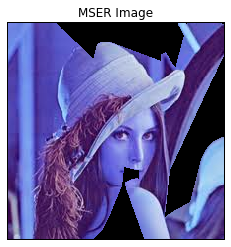

In [32]:
mask = np.zeros((img.shape[0],img.shape[1], 1), dtype=np.uint8)

for contour in hulls:

    cv2.drawContours(mask, [contour], -1, (255, 255, 255), -1)

#this is used to find only text regions, remaining are ignored
text_only = cv2.bitwise_and(img, img, mask=mask)

#cv2.imshow("text only", text_only)

#cv2.waitKey(0)

plt.imshow(text_only)
plt.title('MSER Image')
plt.axis('off')
plt.show()

### Hough transform

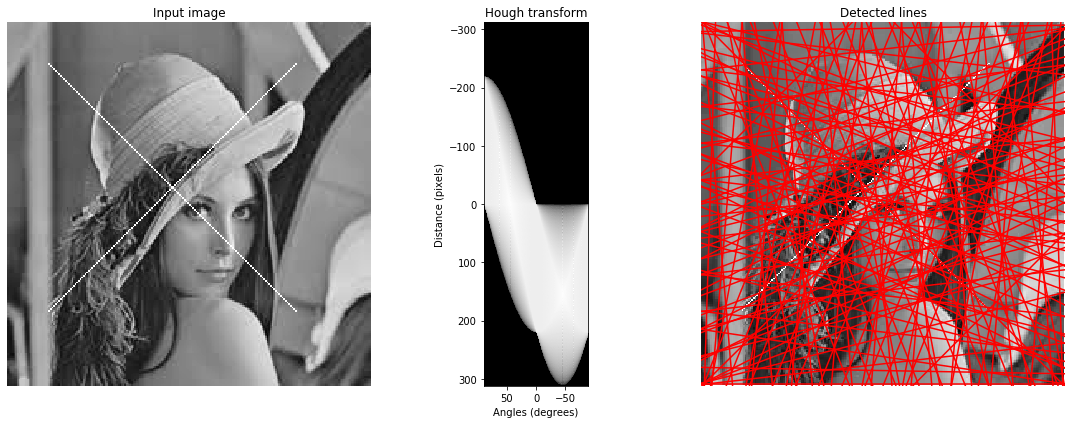

In [33]:
import numpy as np
import cv2
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage import data

import matplotlib.pyplot as plt
from matplotlib import cm


# Constructing test image
image = cv2.imread('/home/shri/Downloads/IMG.jpeg',0)

#image = np.zeros((200, 200))
idx = np.arange(25, 175)
image[idx[::-1], idx] = 255
image[idx, idx] = 255

# Classic straight-line Hough transform
# Set a precision of 0.5 degree.
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360)
h, theta, d = hough_line(image, theta=tested_angles)

# Generating figure 1
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(np.log(1 + h),
             extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
             cmap=cm.gray, aspect=1/1.5)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')

ax[2].imshow(image, cmap=cm.gray)
origin = np.array((0, image.shape[1]))
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    ax[2].plot(origin, (y0, y1), '-r')
ax[2].set_xlim(origin)
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

plt.tight_layout()
plt.show()